In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# SCARED_IGEV.py
#Cargar las imagenes rectificadas para ser procesadas por el modelo IGEV++
#The following code is going to handle Data Loading, Data Pre-Procesing for Traing or Evaluation and Data Augmentation.


import os
import random
import torch
from core.Utils.frame_utils import get_scared_file_pairs, read_image

from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
#import scared_utils the function get_scared_file_pairs and read_images

class RandomFlip:
    """Random horizontal or vertical flip"""
    def __init__(self, horizontal=True, vertical=True):
        self.horizontal = horizontal
        self.vertical = vertical

    def __call__(self, img):
        if self.horizontal and random.random() < 0.5:
            img = F.hflip(img)
        if self.vertical and random.random() < 0.5:
            img = F.vflip(img)
        return img

class SCARED_IGEV(Dataset):
    def __init__(self, root_path, training=True):
        """
        Args:
            root_path (str): Root path to the SCARED dataset.
            training (bool): Whether the dataset is for training or evaluation.
        """
        self.training = training
        self.left_paths, self.right_paths = get_scared_file_pairs(root_path)

        # Define transforms (optional: normalization like ImageNet for pretrained models)
        self.transform_base  = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor()
        ])
        self.transform_train  = transforms.Compose([
            RandomFlip(horizontal=True, vertical=True),
            transforms.ColorJitter(
                brightness=0.2,  # AdjustBrightness
                contrast=0.2,   # AdjustContrast
                saturation=0.2, # AdjustSaturation
                hue=0.1        # AdjustHue
            )
        ])
        """
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]
        )
        """

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left_img = read_image(self.left_paths[idx])
        right_img = read_image(self.right_paths[idx])

        # Apply base transforms
        left_tensor = self.transform_base(left_img)
        right_tensor = self.transform_base(right_img)

        if self.training:

            left_aug = left_tensor.clone()
            left_aug = (left_aug - left_aug.min()) / (left_aug.max() - left_aug.min())
            left_aug = self.transform_train(left_aug)
            return left_aug, left_tensor, right_tensor

        else:

            left_aug = left_tensor.clone()
            return left_aug, left_tensor, right_tensor


In [43]:
from torch.utils.data import DataLoader

def get_scared_dataloader(args, train=True):
    dataset = SCARED_IGEV(args.data_path, training=train)

    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=args.shuffle,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=train
    )

    return dataloader, len(dataset)

In [48]:
class Args:
    data_path = '/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/'
    batch_size = 10
    shuffle = True
    num_workers = 0

args = Args()
dataloader, dataset_size = get_scared_dataloader(args, train=True)

dataset_1
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1
keyframe keyframe_1
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/rectified_video_frame/left
keyframe keyframe_2
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_2/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_2/rectified_video_frame/left
keyframe keyframe_3
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_3/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_3/rectified_video_frame/left
keyframe keyframe_4
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_4/rectified_video_frame
Not found
keyframe keyframe_5
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_5/rectified_video_frame
Not found
dataset_2
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/d

In [49]:
dataloader

In [50]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

data_batch = next(iter(dataloader))
left_aug, left_tensor, right_tensor = data_batch  # Each is a tensor of shape [B, C, H, W]



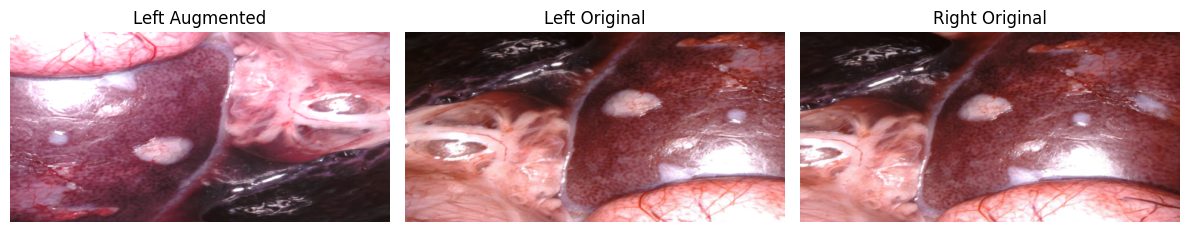

In [55]:
# Pick the first sample in the batch
idx = 8
left_aug_img = F.to_pil_image(left_aug[idx].cpu())
left_orig_img = F.to_pil_image(left_tensor[idx].cpu())
right_orig_img = F.to_pil_image(right_tensor[idx].cpu())

# Plot the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(left_aug_img)
plt.title('Left Augmented')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(left_orig_img)
plt.title('Left Original')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(right_orig_img)
plt.title('Right Original')
plt.axis('off')

plt.tight_layout()
plt.show()